In [1]:
using HTTP, JSON, JLD, Roots, PrettyTables, DotEnv
DEBUG_LEVEL = 1
using Optim, Random
Random.seed!(0)
using BlackBoxOptim, Distributions, ForwardDiff, Integrals, Roots, StatsPlots, DelimitedFiles
cfg = DotEnv.config(path="../.env")
files_path = cfg["files_path"]

"/home/peters/code/mapinator/estimation/current_estimates_and_files/"

In [2]:
adjusted_placement_rates = load(files_path*"adjusted_placement_rates.jld")["adjusted_placement_rates"]
NUMBER_OF_TYPES = size(adjusted_placement_rates, 2)
numtotal = size(adjusted_placement_rates, 1)

12

In [3]:
function F(x, ρ, μ, σ, K)
    return sum([ρ[i] * cdf(truncated(Normal(μ[i], σ[i]), 0, 1), x) for i in 1:K])
end

function f(x, ρ, μ, σ, K)
    return sum([ρ[i] * pdf(truncated(Normal(μ[i], σ[i]), 0, 1), x) for i in 1:K])
end

function G(Fim1, Fx, αsum)
    return (Fim1 - Fx) / αsum
end

function κ(i, t, v_rel)
    return sum([-log(v_rel[j]) for j in t:i-1])
end

function fi(x, μ, σ)
    return pdf(truncated(Normal(μ, σ), 0, 1), x)
end

fi (generic function with 1 method)

In [4]:
function q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
    # Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    # x_vec[s] = x_{s-1}, so the limits of integration are and must be offset by 1 below
    # TODO: can some integrals be cached as a speed-up? can some integrals be computed in parallel?
    return sum([(α[t]/sum(α[1:s])) * solve(IntegralProblem{false}((x, p) -> exp(-(G(Fx_vec[s], F(x, ρ, μ, σ, K), sum(α[1:s])) + κ(s, t, v_rel))) * fi(x, μ[i], σ[i]), x_vec[s+1], x_vec[s]), HCubatureJL())[1] for s in t:k])
end

function Fx(t, α, v_rel)
    return 1 - sum([-log(v_rel[j])*sum(α[1:j]) for j in 1:t])
end

function Q2(ratio, β)
    return β * (1 - exp(-ratio)) / ratio
end

function pi(t, α)
    return α[t] / sum(α[1:t])
end

pi (generic function with 1 method)

In [5]:
function estimate_likelihood(p_vec, placements, k, K, M)
    v_rel = p_vec[1:k-1]
    α = 1.0 * p_vec[k:2k-1] / sum(p_vec[k:2k-1]) # change 1.0 to scale number of graduates vs departments
    μ = p_vec[2k:2k+K-1]
    σ = p_vec[2k+K:2k+2K-1]
    ρ = p_vec[2k+2K:2k+3K-1] / sum(p_vec[2k+2K:2k+3K-1])
    β = p_vec[end] # set = 1 to hardcode
    
    Fx_vec = ones(k) # sets F(x0) = 1 by default; Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    x_vec = ones(k+1) # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0 # TODO: if this case occurs, can we speed up q()?
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        x_vec[t+1] = find_zero(x -> F(x, ρ, μ, σ, K) - Fx_vec[t+1], 0.5) 
    end

    objective = 0.0
    normalizer = 0.0

    q_it = zeros(K, k)
    for i in 1:K
        for t in 1:k
            prob = q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
            q_it[i, t] = prob
            normalizer += ρ[i] * prob
        end
    end

    # TODO: div by zero and negative floating point in mean
    D = sum([ρ[i] * (1 - sum([q_it[i, t] for t in 1:k])) for i in 1:K])
    S = sum([α[t] * (1 - sum([ρ[i]*q_it[i, t] for i in 1:K])) for t in 1:k])
    for i in 1:K
        for t in 1:k
            prob = (1 - sum([q_it[i, s] for s in 1:k])) * Q2(D/S, β) * α[t] * (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])) / S
            # println(sum([q_it[i, s] for s in 1:k]))
            # println(t, " ", i, " ", ρ[i] * (q_it[i, t] + prob), " ", ρ[i], " ", q_it[i, t], " ", (1 - sum([q_it[i, s] for s in 1:k])), " ", Q2(D/S, β), " ", α[t], " ", (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])), " ", S, " ", prob)
            objective += placements[i, t] * (log(ρ[i] * (q_it[i, t] + prob)))
            normalizer += ρ[i] * prob
        end
    end
    
    objective -= M * log(normalizer)
    return -objective
end

function print_metrics_maximum_likelihood(p_vec, placements, k, K, M)
    v_rel = p_vec[1:k-1]
    α = 1.0 * p_vec[k:2k-1] / sum(p_vec[k:2k-1]) # change 1.0 to scale number of graduates vs departments
    μ = p_vec[2k:2k+K-1]
    σ = p_vec[2k+K:2k+2K-1]
    ρ = p_vec[2k+2K:2k+3K-1] / sum(p_vec[2k+2K:2k+3K-1])
    β = p_vec[end] # set = 1 to hardcode

    Fx_vec = ones(k)
    x_vec = ones(k+1)
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        x_vec[t+1] = find_zero(x -> F(x, ρ, μ, σ, K) - Fx_vec[t+1], 0.5) 
    end

    objective = 0.0
    likelihood = 0.0
    normalizer = 0.0
    
    q_it = zeros(K, k)
    for i in 1:K, t in 1:k
        prob = q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
        q_it[i, t] = prob
        normalizer += ρ[i] * prob
    end
    
    # TODO: div by zero and negative floating point in mean
    D = sum([ρ[i] * (1 - sum([q_it[i, t] for t in 1:k])) for i in 1:K])
    S = sum([α[t] * (1 - sum([ρ[i]*q_it[i, t] for i in 1:K])) for t in 1:k])
    round_2 = zeros(K, k)
    round_2_hiring = zeros(K, k)

    for i in 1:K, t in 1:k
        prob = (1 - sum([q_it[i, s] for s in 1:k])) * Q2(D/S, β) * α[t] * (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])) / S
        round_2[i, t] = prob
        round_2_hiring[i, t] = Q2(D/S, β) * α[t] * (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])) / S
        normalizer += ρ[i] * prob
    end

    round_1_failure = zeros(K)
    for i in 1:K
        round_1_failure[i] = (1 - sum([q_it[i, s] for s in 1:k]))
    end
    
    exp_placements_round_1 = zeros(K, k)
    exp_placements_round_2 = zeros(K, k)
    exp_placements = zeros(K, k)
    for i in 1:K, t in 1:k 
        expectation = M * (ρ[i] * (q_it[i, t] + round_2[i, t]) / normalizer)
        exp_placements_round_1[i, t] = M * (ρ[i] * q_it[i, t] / normalizer)
        exp_placements_round_2[i, t] = M * (ρ[i] * round_2[i, t] / normalizer)
        exp_placements[i, t] = expectation
        objective += (placements[i, t] - expectation) ^ 2 / expectation
        likelihood += placements[i, t] * (log(ρ[i] * (q_it[i, t] + round_2[i, t])))
        likelihood -= log(factorial(big(placements[i, t])))
    end
    likelihood -= M * log(normalizer)

    println("chi-square objective value = ", objective)
    println("log-likelihood objective value = ", likelihood)
    println("likelihood objective value = ", exp(likelihood))
    println("success sample size (departments) = ", M)
    println("estimated total samples (departments) = ", M / normalizer)
    println("estimated unmatched departments = ", (M / normalizer) - M)
    println("probability of any success: ", normalizer)
    println("probability of no success: ", 1 - normalizer)
    println("measure of departments in round 2 = ", D)
    println("measure of graduates in round 2 = ", S)
    println()
    println("predicted fraction of departments of each tier:")
    display(ρ)
    println()
    println("fractions observed among successful departments in data:")
    display(sum(placements, dims = 2) ./ M)
    println()

    for i in 1:k
        println("pi_", i, " = ", pi(i, α))
    end
    println()

    offer_targets = zeros(k, k)
    for t in 1:k, j in 1:t
        offer_targets[t, j] = pi(j, α) * prod([1 - pi(i, α) for i in j+1:t])
    end
    println("Tier selection probabilities for making offers:")
    display(offer_targets)
    println()

    println("Round 1 hiring probabilities:")
    display(q_it)
    println()

    println("Probabilities of failing round 1")
    display(round_1_failure)
    println()

    println("Probabilities of failing round 1 and hiring in round 2:")
    display(round_2)
    println()

    println("Round 2 hiring probabilities:")
    display(round_2_hiring)
    println()

    for i in 1:k+1
        println("x_", i - 1, " = ", x_vec[i])
    end
    println()
    for i in 1:k
        println("F(x_", i - 1, ") = ", Fx_vec[i])
    end
    println()
    for i in 1:k
        println("α_", i, " = ", α[i])
        println("  Est. graduates: ", α[i] * (M / normalizer - 1))
        println("  Successful: ", sum(placements[:, i]))
        println("  Unsuccessful: ", (α[i] * (M / normalizer - 1)) - sum(placements[:, i]))
    end
    println("Total estimated graduates: ", sum(α) * (M / normalizer - 1))
    println("Total successful graduates: ", M)
    println("Total estimated unsuccessful graduates: ", (sum(α) * (M / normalizer - 1)) - M)
    println("β = ", β)
    println()
    println("estimated placement rates, round 1 only:")
    display(exp_placements_round_1)
    println()
    println("estimated placement rates, round 2 only:")
    display(exp_placements_round_2)
    println()
    println("estimated placement rates, cumulative:")
    display(exp_placements)
    println()
    println("actual placement rates:")
    display(placements)
    println()
    println("difference between estimated and actual placement rates:")
    display(exp_placements - placements)
    println()
    println("chi-square p-value")
    println(1 - cdf(Chisq((size(placements)[1] - 1) * (size(placements)[2] - 1)), objective))
end

print_metrics_maximum_likelihood (generic function with 1 method)

In [6]:
k = NUMBER_OF_TYPES
K = numtotal
M = sum(adjusted_placement_rates)

# upper bound on the value ratios, which should all be less than 1
# if any ratio turns out to be 1.0 or close to it at optimality, this could indicate that a lower tier has a higher value than a higher one
upper = [1.0 for _ in 1:k-1] 

# upper bound on variables proportionate to alpha
append!(upper, [1.0 for _ in 1:k])

# upper bound on the mu parameter of truncated normal, which is strictly within [0, 1] as the mean is greater than mu in truncated normal
append!(upper, [1.0 for _ in 1:K])

# upper bound on the sigma parameter of truncated normal
append!(upper, [5.0 for _ in 1:K])

# upper bound on variables proportionate to rho
append!(upper, [1.0 for _ in 1:K])

# upper bound on beta friction parameter
push!(upper, 1.0)

# all lower bounds are zero as these should be positive parameters
# can swap estimate_likelihood for chi_square
sol_res = bboptimize(p -> estimate_likelihood(p, adjusted_placement_rates, k, K, M), SearchRange = [(0.0, upper[i]) for i in eachindex(upper)], MaxFuncEvals = 100000, TraceInterval = 5)
sol = best_candidate(sol_res)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
5.01 secs, 958 evals, 853 steps, improv/step: 0.327 (last = 0.3271), fitness=128786.905651450
10.02 secs, 1912 evals, 1807 steps, improv/step: 0.300 (last = 0.2767), fitness=127272.545129988
15.03 secs, 2899 evals, 2794 steps, improv/step: 0.281 (last = 0.2442), fitness=125853.560602647
20.03 secs, 3877 evals, 3772 steps, improv/step: 0.259 (last = 0.1963), fitness=125124.361083266
25.04 secs, 4868 evals, 4763 steps, improv/step: 0.237 (last = 0.1524), fitness=125004.257577418
30.04 secs, 5808 evals, 5703 steps, improv/step: 0.225 (last = 0.1638), fitness=124524.726742576
35.04 secs, 6745 evals, 6640 steps, improv/step: 0.215 (last = 0.1558), fitness=124141.215679805
40.04 secs, 7663 evals, 7558 steps, improv/step: 0.206 (last = 0.1416), fitness=124043.621779624
45.04 secs, 8530 evals,

46-element Vector{Float64}:
 0.701742199252241
 0.8050747842342345
 0.7823907974763755
 0.47559609205446834
 0.6598394686965432
 0.7939269665773694
 0.8016152390425609
 0.6020187071261519
 0.9993066212203724
 0.9978991391318092
 0.5636377962324257
 0.4667036026753752
 0.2297818006122016
 ⋮
 0.2468033780730877
 0.583502382786866
 0.360178723292357
 0.04688576701873307
 0.33938555087709205
 0.32175104570298274
 0.9979775808117669
 0.3157362305647034
 0.01364789268637752
 0.7995984759818882
 0.7767919906145572
 0.14276723876285022

In [7]:
# uncomment this after estimation if you want detailed estimates

# ensure the correct metrics function is used based on the selected optimizer
#print_metrics_maximum_likelihood(sol, adjusted_placement_rates, k, K, M)


In [8]:
v_base = 1
type_values = []
type_headers = []
row_names = ["Graduate Values"]
for i in 1:k
 #   println("v", i, ": ", v_base)
    push!(type_values, v_base)
    push!(type_headers, string("Tier ", i))
    if i != k
        v_base = sol[i] * v_base
    end
end
data = Vector{Float64}(type_values)
head = Vector{String}(type_headers)
#println(size(data,2), " " , size(data,1))
#println(Vector{String}(type_headers))
#println(row_names)
#pretty_table(data', header = head, row_names=row_names)
means_by_type = []
std_by_type = []
for select_type in 1:k
    push!(means_by_type, mean(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0 ,1)))
    push!(std_by_type, std(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0 ,1)))
   
    #println("mean for type ", select_type, ": ", mean(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
    #println("stddev for type ", select_type, ": ", std(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
    #println()
end
datam = Vector{Float64}(means_by_type)
datas = Vector{Float64}(std_by_type)
shares = 1.0 * sol[k:2k-1] / sum(sol[k:2k-1]) # change 1.0 to scale number of graduates vs departments
all_data = hcat(data, datam, datas, shares )
push!(row_names, "Mean offer value")
push!(row_names, "Offers, std deviation")
push!(row_names, "Tier Shares")

#println(all_data)    
pretty_table(all_data', header = head, row_names=row_names)

#for select_type in k+1:K
#    println("mean for sink ", select_type - k, ": ", mean(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
#    println("stddev for sink ", select_type - k, ": ", std(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
#    println()
#end

┌───────────────────────┬──────────┬──────────┬──────────┬──────────┬─────────────┐
│                       │   Tier 1 │   Tier 2 │   Tier 3 │   Tier 4 │      Tier 5 │
├───────────────────────┼──────────┼──────────┼──────────┼──────────┼─────────────┤
│       Graduate Values │      1.0 │ 0.701742 │ 0.564955 │ 0.442016 │    0.210221 │
│      Mean offer value │ 0.727794 │ 0.554136 │ 0.466902 │ 0.229801 │   0.0826889 │
│ Offers, std deviation │ 0.201888 │ 0.203076 │ 0.141011 │ 0.060774 │ 0.000253296 │
│           Tier Shares │ 0.171089 │ 0.205856 │  0.20785 │ 0.156097 │    0.259109 │
└───────────────────────┴──────────┴──────────┴──────────┴──────────┴─────────────┘


In [13]:
save(files_path*"current_estimates.jld", "all_data", all_data)

In [14]:
open(files_path*"current_estimates.tex", "w") do f
pretty_table(
    f,
    all_data',
    header = head,
        row_names = row_names,
    backend = Val(:latex)
    )
end

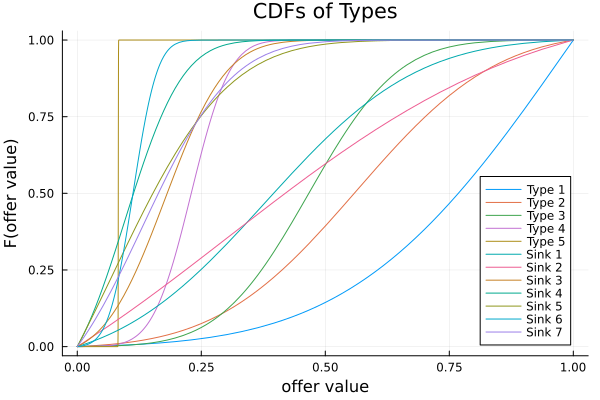

In [11]:
# https://github.com/JuliaPlots/StatsPlots.jl/blob/master/README.md
# https://docs.juliaplots.org/latest/tutorial/

select_type = 1
cdfs = plot(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = cdf, title = "CDFs of Types", label = "Type 1")
for select_type in 2:NUMBER_OF_TYPES # academic types
    plot!(cdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = cdf, label = string("Type ", select_type))
end

for select_type in k+1:K # sinks
    plot!(cdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = cdf, label = string("Sink ", select_type - k))
end
xlabel!(cdfs, "offer value")
ylabel!(cdfs, "F(offer value)")
savefig(cdfs, "cdfs.png")
cdfs

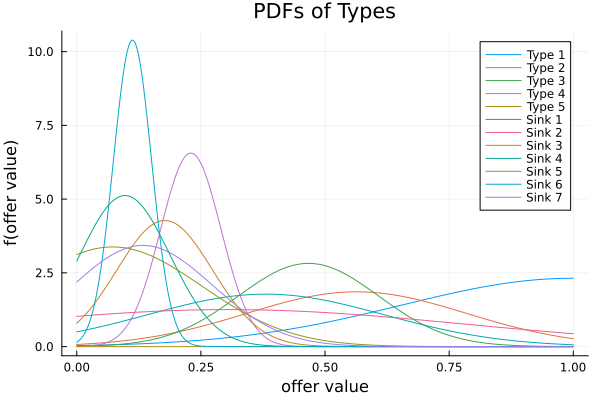

In [12]:
select_type = 1
pdfs = plot(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = pdf, title = "PDFs of Types", label = "Type 1")
for select_type in 2:k # academic types
    plot!(pdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = pdf, label = string("Type ", select_type))
end

for select_type in k+1:K # sinks
    plot!(pdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = pdf, label = string("Sink ", select_type - k))
end
xlabel!(pdfs, "offer value")
ylabel!(pdfs, "f(offer value)")
savefig(pdfs, "pdfs.png")
pdfs